<a href="https://colab.research.google.com/github/aaryan-gulia/UCLBnF-Algorithmic-Research/blob/main/crypto_mean_reversion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mean Reversion Strategies in Cryptocurrency: A Practical Overview

In the realm of financial markets, mean reversion represents a fundamental concept rooted in the tendency of asset prices to revert to their historical average or mean over time.

# Stationarity: The Backbone of Mean Reversion

## Understanding Stationarity

In the realm of time series analysis, the notion of stationarity is paramount. A stationary time series is one whose statistical properties, such as mean, variance, and autocorrelation, remain constant over time. Why does this matter? Because stationarity forms the bedrock for several statistical techniques and models, including mean reversion strategies.

## Theoretical Foundations

1. **Weak Stationarity:**
   - A time series is weakly stationary if its mean and variance are constant over time, and the covariance between any two time points depends only on the time lag. Mathematically, for a series &mu; (mean) and &sigma;<sup>2</sup> (variance) being constant, and Cov(X<sub>t</sub>, X<sub>t-k</sub>) being a function solely of k.

2. **Dickey-Fuller Test for Stationarity:**
   - The Augmented Dickey-Fuller (ADF) test, introduced in our overview, is a powerful tool for assessing stationarity. The null hypothesis of the test is that the series has a unit root, indicating non-stationarity. By examining the ADF statistic and p-value, we can make informed decisions about the stationarity of a time series.

## Practical Implications

**1. Why Stationarity Matters in Finance:**
   - In financial markets, the assumption of stationarity is crucial for the application of various models. When time series' exhibit stationarity, historical patterns become more reliable indicators of future movements. This is particularly relevant for mean reversion strategies, where the assumption is that prices will revert to a stable mean.

**2. Example: Cryptocurrency Price Series:**
   - Consider a hypothetical scenario where the daily closing prices of a cryptocurrency exhibit a clear upward trend over time. If this series is non-stationary, predicting future prices based on historical patterns becomes challenging. On the other hand, a stationary series allows for more robust analysis and model building.

## Prices are RARELY Stationary

Price series in modern markets are rareley, if ever, stationary. Hence,we need to use two principles to work with mean-reversion strategies:

- We don't need a time-series to be truly stationary to be able to extract value out of short-term stationarity assumptions, especially in medium and high frequence strategies.

- Non-stationary time-series which may have fixed long-term of short-term correlations can be cointegrated to build a near-stationary portfolio.


In [1]:
import requests
import pandas as pd
import numpy as np
from plotly import graph_objects as go

In [2]:
def kraken_api_data(symbol, timeframe, extract):

  # Fetch OHLCV data from Kraken
  url = f'https://api.kraken.com/0/public/OHLC?pair={symbol}&interval={timeframe}'

  # Make the API request
  response = requests.get(url)
  data = response.json()

  # Extract OHLCV data
  ohlc_data = data['result'][extract]

  # Convert the data to a DataFrame
  columns = ['timestamp', 'open', 'high', 'low', 'close', 'volume', 'wavg price', 'count']
  df = pd.DataFrame(ohlc_data, columns=columns)

  # Convert Unix timestamp to datetime format
  df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')

  # Convert 'open', 'high', 'low', 'close', 'volume', 'wavg_price' to numeric type
  string_columns = ['open', 'high', 'low', 'close', 'volume', 'wavg price']
  df[string_columns] = df[string_columns].apply(pd.to_numeric, errors='coerce')
  df.set_index('timestamp', inplace = True)

  return df

In [3]:
timeframe = "1440"
eth_df = kraken_api_data("ETHUSD",timeframe,"XETHZUSD")
eth_df.head()

,open,high,low,close,volume,wavg price,count
timestamp,,,,,,,
2021-12-15,3861.40,4094.04,3650.00,4019.80,3905.32,58162.251819,42146
2021-12-16,4019.80,4121.84,3955.00,3959.04,4045.61,30802.849939,24210
2021-12-17,3959.04,3993.96,3696.69,3877.50,3867.43,36714.166299,30648
2021-12-18,3876.40,3999.00,3769.78,3961.35,3917.93,23546.201329,19940
2021-12-19,3961.94,4035.58,3890.00,3924.37,3947.60,20352.155080,17690


## Augmented Dickey-Fuller (ADF) Test: Unraveling Time Series Stationarity


The Augmented Dickey-Fuller (ADF) test is a crucial statistical tool employed in time series analysis to assess the stationarity of a given dataset.

### Theoretical Foundations

#### Understanding Unit Root and Non-Stationarity

The ADF test revolves around the concept of a unit root. A unit root exists in a time series if the process is non-stationary, meaning its statistical properties change over time. The presence of a unit root implies that the series has a long-term trend that needs to be addressed for accurate analysis.

#### ADF Test Statistic

The ADF test involves regressing the differenced series on its lagged values. The null hypothesis (\(H_0\)) assumes the presence of a unit root, indicating non-stationarity. The test statistic is then compared to critical values to determine whether to reject the null hypothesis.

#### Critical Values and Decision Criteria

The ADF test provides critical values corresponding to different levels of significance (e.g., 1%, 5%, and 10%). If the ADF statistic is more negative than the critical values, we reject the null hypothesis, indicating stationarity. Conversely, if the statistic is less negative than the critical values, we fail to reject the null hypothesis, suggesting non-stationarity.

### Practical Implications

#### ADF Test in Finance

In financial markets, the ADF test plays a pivotal role in validating the assumptions required for reliable modeling. If a time series exhibits stationarity, historical patterns become more trustworthy for predicting future price movements. For mean reversion strategies, where the expectation is that prices will revert to a stable mean, assessing stationarity is fundamental.

#### Code Implementation

Let's apply the ADF test to a practical example using Python and the `statsmodels` library:


In [4]:
import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

In [5]:
statistic = adfuller(eth_df['close'])

In [6]:
eth_t_statistic = statistic[0]
eth_p_value = statistic[1]
eth_critical_values = statistic[4]

print(f"ADF Test Statistic: {eth_t_statistic: 0.4f}")
print(f"P-value of ADF test: {eth_p_value: 0.4f}")
print(f"Critical values:")
print(f"1%: {eth_critical_values['1%']: 0.4f} \n5%: {eth_critical_values['5%']: 0.4f} \n10%: {eth_critical_values['10%']: 0.4f}")

ADF Test Statistic: -3.1198
P-value of ADF test:  0.0251
Critical values:
1%: -3.4395 
5%: -2.8656 
10%: -2.5689


# Hurst Exponent: Navigating the Persistence of Time Series

## Introduction

The Hurst Exponent is a key metric in time series analysis, shedding light on the long-term memory and persistence of a given dataset. In the realm of mean reversion strategies, understanding the Hurst Exponent becomes crucial for gauging whether a time series is more likely to revert to a stable mean or persist in its trend.

## Theoretical Foundations

### Rescaled Range and Hurst Exponent

The Hurst Exponent (\(H\)) is derived from the rescaled range, a measure of the variability of a time series. For a time series \(X\) of length \(N\), the rescaled range \(R/S\) is calculated by dividing the range of the first \(n\) observations by the standard deviation. The Hurst Exponent is then defined as the limit, as \(n\) approaches infinity, of the expected value of $\frac{R_n}{S_n}$.

### Interpreting Hurst Exponent Values

1. $H < 0.5$: Implies anti-persistence. The time series tends to revert to the mean, indicating a mean-reverting behavior.
2. $H = 0.5$: Suggests a random walk. The series exhibits no significant trend or mean-reverting behavior.
3. $H > 0.5$: Indicates persistence. The time series has a tendency to follow trends, suggesting that future values are more likely to continue the current trend.

## Practical Implications

### Using Hurst Exponent in Trading

#### Mean Reversion Strategies:
- A low Hurst Exponent $H < 0.5$ is indicative of mean-reverting behavior. Traders can explore mean reversion strategies, expecting prices to revert to historical averages.

#### Trend-Following Strategies:
- A high Hurst Exponent $H > 0.5$ suggests a persistent trend. Traders may consider trend-following strategies, anticipating that current trends will continue.

### Code Implementation

Let's calculate the Hurst Exponent for a cryptocurrency price series using Python:



In [7]:
from numpy import cumsum, log, polyfit, sqrt, std, subtract
from numpy.random import randn

In [8]:
def hurst(ts):
    """
    Returns the Hurst Exponent of the time series vector ts

    Parameters
    ----------
    ts : `numpy.array`
        Time series upon which the Hurst Exponent will be calculated

    Returns
    -------
    'float'
        The Hurst Exponent from the poly fit output
    """
    # Create the range of lag values
    lags = range(2, 100)

    # Calculate the array of the variances of the lagged differences
    tau = [sqrt(std(subtract(ts[lag:], ts[:-lag]))) for lag in lags]
    # Use a linear fit to estimate the Hurst Exponent
    poly = polyfit(log(lags), log(tau), 1)

    # Return the Hurst exponent from the polyfit output
    return poly[0]*2.0

In [9]:
eth_hurst_exp = hurst(list(eth_df['close']))
print(f"Hurst Exponent: {eth_hurst_exp}")

Hurst Exponent: 0.45830009471540195


In [10]:
btc_df = kraken_api_data("BTCUSD",timeframe,"XXBTZUSD")
btc_df.head()

,open,high,low,close,volume,wavg price,count
timestamp,,,,,,,
2021-12-15,48399.2,49512.5,46632.0,48881.3,48245.8,4250.481708,34511
2021-12-16,48881.8,49465.6,47560.0,47631.0,48550.4,3345.273837,31997
2021-12-17,47639.9,48001.9,45500.0,46168.3,46755.3,3794.875796,38927
2021-12-18,46166.6,47333.6,45520.2,46864.3,46435.6,1868.987500,24363
2021-12-19,46858.0,48289.0,46484.8,46688.4,47340.2,2067.319741,22744


In [11]:
statistic = adfuller(btc_df['close'])

btc_t_statistic = statistic[0]
btc_p_value = statistic[1]
btc_critical_values = statistic[4]

print(f"ADF Test Statistic: {btc_t_statistic: 0.4f}")
print(f"P-value of ADF test: {btc_p_value: 0.4f}")
print(f"Critical values:")
print(f"1%: {btc_critical_values['1%']: 0.4f} \n5%: {btc_critical_values['5%']: 0.4f} \n10%: {btc_critical_values['10%']: 0.4f}")

ADF Test Statistic: -2.2334
P-value of ADF test:  0.1943
Critical values:
1%: -3.4396 
5%: -2.8656 
10%: -2.5689


In [12]:
btc_hurst_exp = hurst(list(btc_df['close']))
print(f"Hurst Exponent: {btc_hurst_exp}")

Hurst Exponent: 0.49133901633910365


## Graphical Techniques for Exploring Stationarity


Graphical techniques play a pivotal role in unraveling the stationarity dynamics between different data series. Understanding how to leverage scatter plots and various metrics like ratios, absolute returns, and log returns enhances our ability to discern patterns and make informed decisions regarding stationarity.

### Scatter Plots: Unveiling Relationships

#### Purpose of Scatter Plots

Scatter plots serve as a powerful tool to visualize the relationship between two variables. In the context of stationarity, plotting one time series against another can offer insights into potential co-movements, trends, or mean-reverting behavior.

### Interpretation:
A scattered distribution may indicate a lack of a clear relationship.
A linear pattern might suggest a potential co-movement, requiring further investigation into stationarity.


In [13]:
fig = go.Figure()

fig.add_trace(go.Scatter(x = eth_df["close"], y = btc_df["close"], mode='markers'))

fig.update_layout(title='BTC vs ETH scatter plot',
                     xaxis_title = "ETH prices",
                     yaxis_title= "BTC prices")

fig.show()

## Beta-Hedging with OLS: Creating a Stationary Time Series

Beta-hedging is a risk management strategy that involves adjusting the exposure of a portfolio to offset its systematic risk. Utilizing Python's statsmodels library and the Ordinary Least Squares (OLS) model, we can calculate the beta coefficient, a measure of an asset's sensitivity to market movements, and employ beta-hedging techniques create a near-stationary portfolio.

### Theoretical Foundations

#### Understanding Beta

Beta ($\beta$) measures the volatility of an asset in relation to the overall market. A beta of 1 indicates the asset moves in line with the market, while a beta greater than 1 suggests higher volatility, and a beta less than 1 indicates lower volatility.

#### Beta-Hedging with OLS

The OLS model is commonly used to calculate beta. In the context of beta-hedging, we seek to construct a portfolio with offsetting beta values, aiming to reduce the portfolio's overall sensitivity to market fluctuations.

#### Code Implementation

Let's demonstrate beta-hedging using Python:


In [14]:
def create_residuals(ts_1,ts_2):
    """
    Calculate the OLS and create the beta hedge ratio and residuals for the two
    time series. We use the statsmodel.api libary's OLS model.

    Parameters
    ----------
    ts_1 and ts_2 : two time series lists

    Returns
    -------
    price_df : list of residuals
    beta_hr : beta hedge ratio
    """
    # Create an Ordinary Least Squares regression model
    Y = ts_1
    x = ts_2
    x = sm.add_constant(x)
    model = sm.OLS(Y, x)
    res = model.fit()

    # Beta hedge ratio (coefficent from OLS)
    beta_hr = res.params[1]
    print(f'Beta Hedge Ratio: {beta_hr}')

    # Residuals
    price_df = pd.DataFrame(res.resid, columns = ["spread"])
    return price_df, beta_hr

In [15]:
eth_btc_resid, beta_hr = create_residuals(eth_df['close'], btc_df['close'])
eth_btc_resid.head()

Beta Hedge Ratio: 0.07264426382102576


,spread
timestamp,
2021-12-15,610.873958
2021-12-16,640.941081
2021-12-17,665.657845
2021-12-18,698.947438
2021-12-19,674.745564


In [16]:
statistic = adfuller(eth_btc_resid['spread'])

btc_t_statistic = statistic[0]
btc_p_value = statistic[1]
btc_critical_values = statistic[4]

print(f"ADF Test Statistic: {btc_t_statistic: 0.4f}")
print(f"P-value of ADF test: {btc_p_value: 0.4f}")
print(f"Critical values:")
print(f"1%: {btc_critical_values['1%']: 0.4f} \n5%: {btc_critical_values['5%']: 0.4f} \n10%: {btc_critical_values['10%']: 0.4f}")

ADF Test Statistic: -1.9708
P-value of ADF test:  0.2995
Critical values:
1%: -3.4395 
5%: -2.8656 
10%: -2.5689


In [17]:
btc_hurst_exp = hurst(list(eth_btc_resid['spread']))
print(f"Hurst Exponent: {btc_hurst_exp: 0.4f}")

Hurst Exponent:  0.3921


In [18]:
!pip install arch

## Variance Ratio Test:

The Variance Ratio Test is a statistical method used to assess the presence of long-term dependence or serial correlation in a time series. Employing the `arch.unitroot` library in Python, we can conduct the variance ratio test to scrutinize the efficiency of information diffusion over different time intervals.

### Theoretical Foundations

#### Understanding Variance Ratio

The variance ratio is a measure of how rapidly information is incorporated into asset prices. A variance ratio close to 1 suggests efficient information diffusion, while deviations may indicate inefficiencies or trends in the market.

#### Variance Ratio Test with `arch.unitroot`

The `VarianceRatio` function in the `arch.unitroot` module allows us to conduct the variance ratio test. By specifying different time intervals, we can explore whether the series under consideration exhibits long-term dependence.

#### Implications
- Test Statistic and P-value Interaction:
A significant test statistic (far from 1) with a small p-value implies evidence against efficient information diffusion.
A non-significant test statistic with a high p-value suggests adherence to the null hypothesis.

#### Code Implementation

Let's perform the variance ratio test using Python:



In [19]:
from arch.unitroot import VarianceRatio

In [20]:
VarianceRatio(eth_btc_resid['spread'])

Test Statistic,-0.502
P-value,0.615
Lags,2


In [21]:
import plotly.graph_objects as go

In [22]:
fig = go.Figure()

fig.add_trace(go.Scatter(x = eth_btc_resid.index.values, y = eth_btc_resid["spread"]))

fig.update_layout(title='BTC/ETH beta hedged Spread',
                     xaxis_title='Date',
                     yaxis_title='Spread')

fig.show()

## Half-Life in Mean-Reversion

In the realm of time series analysis and mean-reversion strategies, the concept of half-life plays a crucial role. It provides insights into the speed at which a time series tends to revert to its mean, offering traders and analysts a valuable metric for making informed decisions.

### Theoretical Foundations

#### Understanding Half-Life

In the context of mean reversion, the half-life is a measure of the time it takes for a time series to correct approximately half of its deviation from the mean. It quantifies the speed of mean reversion, informing traders about the expected duration for a series to move towards its long-term average.

#### The Ornstein-Uhlenbeck Process

The Uhlenbeck equation, derived from the Ornstein-Uhlenbeck process, provides a mathematical framework for modeling mean-reverting processes. The equation is expressed as:

$ \Delta y_t = -\lambda (y_t - \mu) \Delta t + \sigma \epsilon_t $

Where:
- $ \Delta y_t $ is the change in the time series at time $ t $.
- $ \lambda $ is the speed of mean reversion.
- $ y_t $ is the current value of the time series.
- $ \mu $ is the mean to which the time series reverts.
- $ \Delta t $ is the time increment.
- $ \sigma $ is the volatility.
- $ \epsilon_t $ is a random shock.

#### Half-Life Calculation

The half-life $(\ T_{1/2} )$ can be estimated from the Uhlenbeck equation as:

$ T_{1/2} = \frac{\ln(2)}{\lambda} $

This formula provides the expected time for the time series to revert halfway to its mean.

#### Code Implementation

In [23]:
#Run OLS regression on spread series and lagged version of itself

def half_life(ts):
  """
  This function calculates the halflife of the mean reverion for a given time series

  Parameters
    ----------
    ts : a time series list

    Returns
    -------
    half_life : the halflife float

  """
  # Lag the residuals
  lagged_residuals = ts.shift(1).dropna()

  diff_residuals_lagged = ts.diff().dropna()

  # Add a constant to the lagged residuals
  lagged_residuals_with_const = sm.add_constant(lagged_residuals)

  # Fit an Ordinary Least Squares (OLS) model
  model = sm.OLS(diff_residuals_lagged, lagged_residuals_with_const)
  results = model.fit()

  # Get the speed of mean reversion (theta) from the model
  theta = -results.params[1]

  # Calculate half-life
  half_life = np.log(2) / theta

  return half_life

In [24]:
halflife = half_life(eth_btc_resid["spread"])
print(f"Halflife = {halflife}")

Halflife = 60.54887487353659


## Johansen Test for Cointegration: A Comprehensive Analysis

The Johansen Test for Cointegration is a powerful statistical tool used to analyze the long-term relationships between multiple time series. It goes beyond simple correlation analysis, providing insights into the number of cointegrating vectors and the nature of the relationships among the variables. In this section, we will delve into the theoretical foundations of the Johansen Test, its practical application using the `VECM` module in Python, and the implications of the results for time series analysis and strategy development.

### Theoretical Foundations

#### Understanding Cointegration

Cointegration reflects a long-term equilibrium relationship between two or more time series, suggesting that they move together over time despite short-term fluctuations. In financial markets, cointegration is a crucial concept for identifying pairs of assets that may be suitable for mean-reversion strategies.

#### The Johansen Test

The Johansen Test is based on the Vector Error Correction Model (VECM), which extends the autoregressive model to include both short-term dynamics and long-term equilibrium relationships. The test assesses the presence of cointegration and provides information about the number of cointegrating vectors.

### Practical Implementation

#### Interpretation of Johansen Test Results
- **Eigenvalues and Trace Statistics:**
Eigenvalues indicate the strength of cointegration.
Trace statistics help determine the number of cointegrating vectors.

- **Critical Values:**
Compared to critical values, trace statistics guide the decision to accept or reject the null hypothesis of no cointegration.

#### Practical Implications

- **Identifying Cointegrated Pairs:**
Eigenvalues and trace statistics guide the identification of cointegrated pairs.
Assets with significant cointegration may be suitable for pairs trading or mean-reversion strategies.
Building Trading Strategies

- **Pairs Trading Strategy:**
Select assets with confirmed cointegration from Johansen Test results.
Implement a pairs trading strategy based on deviations from the long-term equilibrium relationship.

- **Portfolio Diversification:**
Cointegrated assets can be strategically included in portfolios for risk diversification.

#### Performing Johansen Test using `statsmodels`

In [25]:
from statsmodels.tsa.vector_ar import vecm

In [26]:
#this method can be used to define the Johansen test and implement it
ethbtc_johres = vecm.coint_johansen((pd.concat((eth_df.rename(columns={"close": "eth"})["eth"],
                                                  btc_df.rename(columns={"close": "btc"})["btc"]),
                                                 axis = 1)),
                                      det_order=0,
                                      k_ar_diff=1)

def joh_output(res):
    output = pd.DataFrame([res.lr2,res.lr1],
                          index=['max_eig_stat',"trace_stat"]).rename(index = {"0": "r <= 0", "1" : "r <= 1"})
    print(output.T,'\n')
    print("Critical values(90%, 95%, 99%) of max_eig_stat\n",res.cvm,'\n')
    print("Critical values(90%, 95%, 99%) of trace_stat\n",res.cvt,'\n')

joh_output(ethbtc_johres)

   max_eig_stat  trace_stat
0     13.935832   13.980320
1      0.044488    0.044488 

Critical values(90%, 95%, 99%) of max_eig_stat
 [[12.2971 14.2639 18.52  ]
 [ 2.7055  3.8415  6.6349]] 

Critical values(90%, 95%, 99%) of trace_stat
 [[13.4294 15.4943 19.9349]
 [ 2.7055  3.8415  6.6349]] 



In [27]:
# these functions (.evec and .eig) give us the eigen vectors and eigen values.
# after analysis the information above, we find that the first column is what we need to use
coint_vec = ethbtc_johres.evec
coint_val = ethbtc_johres.eig

print(f"Eigen Value ({coint_val[0]}) : Eigen Vector ({coint_vec[0,0]},{coint_vec[1,0]}")
print(f"Eigen Value ({coint_val[1]}) : Eigen Vector ({coint_vec[0,1]},{coint_vec[1,1]}")

Eigen Value (0.019222090927663058) : Eigen Vector (0.003587239572215397,-0.0001887069932741934
Eigen Value (6.195899953981635e-05) : Eigen Vector (-0.0027427276250373517,0.00029364624546901084


In [28]:
coint_weights = coint_vec[:,0] # 1st columns of the coint matrix
norm_weights = coint_weights/sum(abs(coint_weights)) #normalising the weights so as to apply to the asstest
# and form a cointegrated portfolio
print(f"Normalised Weights for the cointegrated portfolio: ")
print(f"{norm_weights}")

Normalised Weights for the cointegrated portfolio: 
[ 0.95002392 -0.04997608]


In [29]:
# the dot product of the asset matrix with the normalised weights eigen vector gives the prices of the
# cointegrated portfolio. We use it for two assets but this method can be used to create cointegrated
# porfolio for any number of assets.
coint_prices = pd.DataFrame({"eth" : eth_df["close"], "btc" : btc_df["close"]}).dot(norm_weights)
coint_prices = pd.DataFrame({"spread" : coint_prices})
coint_prices.head()

,spread
timestamp,
2021-12-15,1376.010595
2021-12-16,1380.772230
2021-12-17,1376.407286
2021-12-18,1421.283443
2021-12-19,1394.942350


In [30]:
# we use the halflife function defined previously to calculate the mean-reversion halflife
# of our cointegrated portfolio
halflife = half_life(coint_prices['spread'])
print(f"Halflife = {halflife * int(timeframe) / 1440} days")

Halflife = 39.583813420244496 days


<Axes: xlabel='timestamp'>

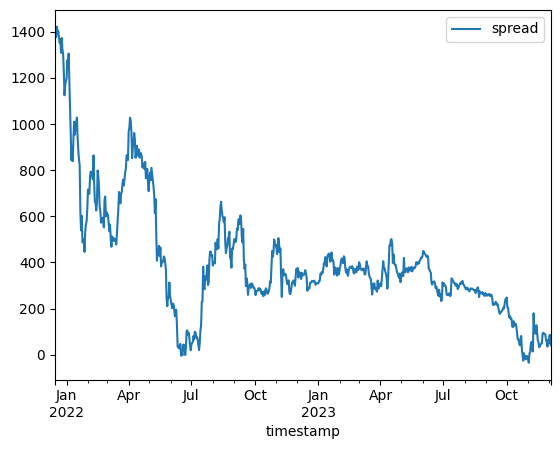

In [31]:
coint_prices.plot()

## A Simple Linear Mean-Reversion Strategy

The below is a simple implementation of mean-reversion in the crypto markets. Note that this cannot be applied as-is to the real world because there is to "maximum" capital deployment.

In [32]:
# We build a simple strategy.

# building the strategy dataframe
strategy_df = pd.DataFrame({"eth" : eth_df['close'], "btc" : btc_df['close']})

# adding the cointegrated portfolio prices
strategy_df['coint_portfolio'] = coint_prices

# Calculating the simple moving average - with a period equal to the halflife
strategy_df['sma_halflife'] = strategy_df['coint_portfolio'].rolling(window=round(halflife)).mean()
strategy_df.dropna(inplace = True)

# This gives the signal of the position we want to hold.
# We take on a position proportional to the different between the coint portfolio and its simple moving average
strategy_df['position'] = -(strategy_df['coint_portfolio'] - strategy_df['sma_halflife'])/(strategy_df['coint_portfolio'] - strategy_df['sma_halflife']).rolling(window=round(halflife)).std()
strategy_df.dropna(inplace = True)
strategy_df.head()

,eth,btc,coint_portfolio,sma_halflife,position
timestamp,,,,,
2022-03-03,2834.87,42465.0,570.960245,646.893035,0.404684
2022-03-04,2622.18,39137.5,535.195050,645.219319,0.612353
2022-03-05,2666.00,39396.4,563.886293,647.147853,0.504009
2022-03-06,2550.39,38416.3,503.035579,647.550037,0.965520
2022-03-07,2492.62,38024.0,467.758312,646.759695,1.330660


In [33]:
# Measuring results of our strategy

# we shift the position by one to remove forward bias
strategy_df['position'] = strategy_df['position'].shift(1)

# daily returns calculation
strategy_df["coint_return"] = strategy_df['coint_portfolio'].pct_change()
strategy_df["eth_return"] = strategy_df['eth'].pct_change()
strategy_df["btc_return"] = strategy_df['btc'].pct_change()
strategy_df.dropna(inplace = True)
strategy_df["strat_return"] = strategy_df["coint_return"] * strategy_df['position']

# cumulative returns calculation
strategy_df['coint_cumulative_return'] = (1 + strategy_df['coint_return']).cumprod() - 1
strategy_df['eth_cumulative_return'] = (1 + strategy_df['eth_return']).cumprod() - 1
strategy_df['btc_cumulative_return'] = (1 + strategy_df['btc_return']).cumprod() - 1
strategy_df['strat_cumulative_return'] = (1 + strategy_df['strat_return']).cumprod() - 1
strategy_df.head()

,eth,btc,coint_portfolio,sma_halflife,position,coint_return,eth_return,btc_return,strat_return,coint_cumulative_return,eth_cumulative_return,btc_cumulative_return,strat_cumulative_return
timestamp,,,,,,,,,,,,,
2022-03-04,2622.18,39137.5,535.195050,645.219319,0.404684,-0.062640,-0.075026,-0.078359,-0.025350,-0.062640,-0.075026,-0.078359,-0.025350
2022-03-05,2666.00,39396.4,563.886293,647.147853,0.612353,0.053609,0.016711,0.006615,0.032828,-0.012390,-0.059569,-0.072262,0.006646
2022-03-06,2550.39,38416.3,503.035579,647.550037,0.504009,-0.107913,-0.043365,-0.024878,-0.054389,-0.118966,-0.100350,-0.095342,-0.048105
2022-03-07,2492.62,38024.0,467.758312,646.759695,0.965520,-0.070129,-0.022651,-0.010212,-0.067711,-0.180752,-0.120729,-0.104580,-0.112558
2022-03-08,2578.19,38752.6,512.639290,648.435102,1.330660,0.095949,0.034329,0.019162,0.127676,-0.102145,-0.090544,-0.087423,0.000746


In [34]:
strategy_df.describe()

,eth,btc,coint_portfolio,sma_halflife,position,coint_return,eth_return,btc_return,strat_return,coint_cumulative_return,eth_cumulative_return,btc_cumulative_return,strat_cumulative_return
count,641.000000,641.000000,641.000000,641.000000,641.000000,641.000000,641.000000,641.000000,641.000000,641.000000,641.000000,641.000000,6.410000e+02
mean,1770.850281,26700.602028,347.958811,365.837233,0.483337,1.985671,0.000291,0.000377,7.813091,-0.390573,-0.375333,-0.371233,1.503792e+10
std,484.907880,7130.364367,195.600832,175.704358,1.595411,51.888491,0.036207,0.028275,208.858428,0.342582,0.171051,0.167912,7.572482e+10
min,994.600000,15760.000000,-34.347305,45.569752,-3.020768,-31.618179,-0.177042,-0.154669,-147.223569,-1.060157,-0.649155,-0.628871,-4.492774e+08
25%,1529.920000,20825.300000,260.144045,288.817060,-0.523461,-0.045031,-0.014305,-0.010683,-0.035482,-0.544375,-0.460321,-0.509589,-8.078962e+03
50%,1689.190000,26511.800000,329.907394,353.186795,0.322162,-0.004213,-0.000268,-0.000622,0.000463,-0.422189,-0.404138,-0.375679,-3.083993e+03
75%,1888.720000,29901.700000,414.902418,389.975936,1.377223,0.037682,0.015524,0.013129,0.036377,-0.273325,-0.333754,-0.295851,-1.233846e+03
max,3523.190000,47440.200000,1027.055412,855.130425,5.732530,1313.018779,0.182807,0.106753,5283.889810,0.798821,0.242805,0.117160,6.365016e+11


In [35]:
fig = go.Figure()

fig.add_trace(go.Scatter(x = strategy_df.index.values, y = strategy_df.eth_cumulative_return * 100, name = "ETH Cumulative Return"))
fig.add_trace(go.Scatter(x = strategy_df.index.values, y = strategy_df.btc_cumulative_return * 100, name = "BTC Cumulative Return"))
fig.add_trace(go.Scatter(x = strategy_df.index.values, y = strategy_df.coint_cumulative_return * 100, name = "Beta-Hedged Cumulative Return"))
fig.add_trace(go.Scatter(x = strategy_df.index.values, y = strategy_df.strat_cumulative_return * 100, name = "Strategy Cumulative Return"))

fig.update_layout(title='Cumulative Returns from ETH, BTC, Beta-Hedged Pair Portfolio, and Strategy',
                     xaxis_title='Date',
                     yaxis_title='Cumulative Returns')

fig.show()

In [36]:
average_strat_return = strategy_df['strat_return'].mean()
strat_vol = strategy_df['strat_return'].std()

sharpe_ratio = average_strat_return/strat_vol * np.sqrt(365)
print(f"Sharpe Ratio of strategy: {sharpe_ratio : 0.4f}")

Sharpe Ratio of strategy:  0.7147


## Bollinger Bands Strategy: Unveiling Price Volatility

The Bollinger Bands strategy is a widely used technical analysis tool designed to measure volatility and identify potential trend reversals in financial markets. In this section, we will explore the theoretical underpinnings of Bollinger Bands, how to implement the strategy using Python, and the practical implications for traders.

### Theoretical Foundations

#### Understanding Bollinger Bands

Bollinger Bands consist of three lines plotted around an asset's price: a middle band being a simple moving average (SMA), and an upper and lower band representing the standard deviations of the price. The width of the bands adjusts with market volatility.

#### Purpose of Bollinger Bands

- **Volatility Measurement:**
  - Bollinger Bands expand during periods of high volatility and contract during low volatility, providing a visual representation of market conditions.

- **Identification of Overbought/Oversold Conditions:**
  - Prices near the upper band may indicate overbought conditions, suggesting a potential reversal.
  - Prices near the lower band may indicate oversold conditions, suggesting a potential upward reversal.

### Practical Implementation

#### Trading Strategies

- **Bollinger Band Squeeze:**
A period of low volatility (narrow bands) often precedes a significant price movement.
- **Reversal Trading:**
Reversal signals may be generated when prices touch or exceed the bands.
- **Trend Following:***
Following the trend when prices consistently ride the upper or lower bands.

#### Code Implementation:


In [55]:
# building the bolinger bands strategy dataframe
strategy_df = pd.DataFrame({"eth" : eth_df['close'], "btc" : btc_df['close']})

# adding the cointegrated portfolio prices
strategy_df['coint_portfolio'] = coint_prices

# moving average and standard distribution
strategy_df['moving_avg'] = strategy_df['coint_portfolio'].rolling(window=round(halflife)).mean()
strategy_df['moving_std'] = strategy_df['coint_portfolio'].rolling(window=round(halflife)).std()
strategy_df.dropna(inplace = True)

# entry and exist point
enter_std = 3
exit_std = 1

# bollinger bands calculation
strategy_df['upper_band'] = strategy_df['moving_avg'] + strategy_df['moving_std'] * enter_std
strategy_df['lower_band'] = strategy_df['moving_avg'] - strategy_df['moving_std'] * enter_std

# strategy signal generation
strategy_df['long_signal'] = np.where(strategy_df['coint_portfolio'] < strategy_df['lower_band'], 1, 0)
strategy_df['short_signal'] = np.where(strategy_df['coint_portfolio'] > strategy_df['upper_band'], -1, 0)
strategy_df['exit_signal'] = np.where((strategy_df['coint_portfolio'] < strategy_df['moving_avg'] + strategy_df['moving_std'] * exit_std) &
                                      (strategy_df['coint_portfolio'] > strategy_df['moving_avg'] - strategy_df['moving_std'] * exit_std)
                                      , 1, 0)

# Combine signals to determine positions
strategy_df['position'] = 0
strategy_df.loc[strategy_df['long_signal'] == 1, 'position'] = 1
strategy_df.loc[strategy_df['short_signal'] == -1, 'position'] = -1

# Forward fill to maintain positions until the next signal
strategy_df['position'] = strategy_df['position'].replace(to_replace=0, method='ffill')

# Use exit position to remove trades when required
strategy_df.loc[strategy_df['exit_signal'] == 1, 'position'] = 0

strategy_df.head()

,eth,btc,coint_portfolio,moving_avg,moving_std,upper_band,lower_band,long_signal,short_signal,exit_signal,position
timestamp,,,,,,,,,,,
2022-01-23,2542.20,36277.5,602.143715,1112.180726,245.411942,1848.416551,375.944902,0,0,0,0
2022-01-24,2442.93,36699.5,486.744936,1089.949085,260.701603,1872.053895,307.844275,0,0,0,0
2022-01-25,2458.31,36987.8,486.948201,1067.603484,273.144399,1887.036681,248.170287,0,0,0,0
2022-01-26,2462.96,36827.6,499.371980,1045.677601,282.752230,1893.934292,197.420911,0,0,0,0
2022-01-27,2426.00,37200.5,445.623017,1021.286091,291.468081,1895.690334,146.881848,0,0,0,0


In [56]:
# Measuring results of our strategy

# we shift the position by one to remove forward bias
strategy_df['position'] = strategy_df['position'].shift(1)

# daily returns calculation
strategy_df["coint_return"] = strategy_df['coint_portfolio'].pct_change()
strategy_df["eth_return"] = strategy_df['eth'].pct_change()
strategy_df["btc_return"] = strategy_df['btc'].pct_change()
strategy_df.dropna(inplace = True)
strategy_df["strat_return"] = strategy_df["coint_return"] * strategy_df['position']

# cumulative returns calculation
strategy_df['coint_cumulative_return'] = (1 + strategy_df['coint_return']).cumprod() - 1
strategy_df['eth_cumulative_return'] = (1 + strategy_df['eth_return']).cumprod() - 1
strategy_df['btc_cumulative_return'] = (1 + strategy_df['btc_return']).cumprod() - 1
strategy_df['strat_cumulative_return'] = (1 + strategy_df['strat_return']).cumprod() - 1
strategy_df.head()

,eth,btc,coint_portfolio,moving_avg,moving_std,upper_band,lower_band,long_signal,short_signal,exit_signal,position,coint_return,eth_return,btc_return,strat_return,coint_cumulative_return,eth_cumulative_return,btc_cumulative_return,strat_cumulative_return
timestamp,,,,,,,,,,,,,,,,,,,
2022-01-24,2442.93,36699.5,486.744936,1089.949085,260.701603,1872.053895,307.844275,0,0,0,0.0,-0.191647,-0.039049,0.011633,-0.0,-0.191647,-0.039049,0.011633,0.0
2022-01-25,2458.31,36987.8,486.948201,1067.603484,273.144399,1887.036681,248.170287,0,0,0,0.0,0.000418,0.006296,0.007856,0.0,-0.191309,-0.032999,0.019580,0.0
2022-01-26,2462.96,36827.6,499.371980,1045.677601,282.752230,1893.934292,197.420911,0,0,0,0.0,0.025514,0.001892,-0.004331,0.0,-0.170676,-0.031170,0.015164,0.0
2022-01-27,2426.00,37200.5,445.623017,1021.286091,291.468081,1895.690334,146.881848,0,0,0,0.0,-0.107633,-0.015006,0.010126,-0.0,-0.259939,-0.045708,0.025443,0.0
2022-01-28,2546.71,37737.9,533.443261,999.748614,294.958022,1884.622680,114.874547,0,0,0,0.0,0.197073,0.049757,0.014446,0.0,-0.114093,0.001774,0.040256,0.0


In [62]:
fig = go.Figure()

fig.add_trace(go.Scatter(x = strategy_df.index.values, y = strategy_df.eth_cumulative_return * 100, name = "ETH Cumulative Return"))
fig.add_trace(go.Scatter(x = strategy_df.index.values, y = strategy_df.btc_cumulative_return * 100, name = "BTC Cumulative Return"))
fig.add_trace(go.Scatter(x = strategy_df.index.values, y = strategy_df.coint_cumulative_return * 100, name = "Beta-Hedged Cumulative Return"))
fig.add_trace(go.Scatter(x = strategy_df.index.values, y = strategy_df.strat_cumulative_return * 100, name = "Strategy Cumulative Return"))

fig.update_layout(title='Cumulative Returns from ETH, BTC, Beta-Hedged Pair Portfolio, and Strategy',
                     xaxis_title='Date',
                     yaxis_title='Cumulative Returns')

fig.show()

In [58]:
average_strat_return = strategy_df['strat_return'].mean()
strat_vol = strategy_df['strat_return'].std()

sharpe_ratio = average_strat_return/strat_vol * np.sqrt(365)

In [60]:
#max drawdown
cumulative_return = (1 + strategy_df['strat_return']).cumprod()

peak = cumulative_return.cummax()

drawdown = (cumulative_return / peak - 1).min()

#compounded annual growth rate
def calculate_cagr(returns):
    total_return = np.prod([x+1 for x in returns])
    num_years = (len(returns) * 1440 / int(timeframe)) / (365) # Assuming daily returns
    cagr = (total_return ** (1 / num_years)) - 1
    return cagr

cagr = calculate_cagr(strategy_df['strat_return'])

#calmar ratio
calmar_ratio = -cagr / drawdown

#sortino ratio
downside_returns = strategy_df['strat_return'][strategy_df['strat_return'] < 0]

sortino_ratio = (cagr / downside_returns.std()) if downside_returns.std() != 0 else np.nan

In [61]:
print(f"Sharpe Ratio:      {sharpe_ratio: 0.3f}")
print(f"Maximum Drawdown:  {drawdown*100: 0.3f}%")
print(f"CAGR:              {cagr*100: 0.3f}%")
print(f"Calmar Ratio:      {calmar_ratio: 0.3f}")
print(f"Sortino Ratio:     {sortino_ratio: 0.3f}")

Sharpe Ratio:       0.700
Maximum Drawdown:  -103.965%
CAGR:              -89.200%
Calmar Ratio:      -0.858
Sortino Ratio:     -0.284
